In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

In [76]:
#Import the Non-League football CSV file containing teams, their league position, their promotion status and their twitter followers
football = pd.read_csv("football_data_final_edit.csv")
#Drop null rows which erroneously came with the CSV 
football.drop([0,1], inplace=True)
#Drop null columns which erroneously came with the CSV
football.drop(["Unnamed: 25","Unnamed: 26","Unnamed: 27","Unnamed: 28"],inplace=True,axis=1)
#Since we dropped some rows, we need to reset the index of the dataframe
football = football.reset_index(drop=True)
#The column headings came from the CSV as the first row, redefine the headings correctly and strip any whitespace with lambda func
strip_whitespace = lambda x: x.strip() 
column_headings = list(map(strip_whitespace,list(football.iloc[0])))
football.columns = column_headings
#Remove the now un-needed dupiclate row containing the column headings and reset the index again.
football.drop(football[football["Step"]=="0"].index,inplace=True)
football.drop(football[football["Step"]=="6"].index,inplace=True)
football.drop([0],inplace=True)
football = football.reset_index(drop=True)
#Let's trim any whitespace from entries and column headings
football =football.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

football.dropna(subset =["Step","League","Gained between 19/4/23 & 29/6/22","2021-22\nPosition","2022-23\nPosition","29.06.22","19.04.23"],how="any",inplace=True)




In [77]:
#For loop to determine whether team improved on their ranking from last season. 2021/22 - 2022/23
positional_improvement = []
for i in range(0,len(football)):
    if float(football.iloc[i]["2022-23\nPosition"]) < float(football.iloc[i]["2021-22\nPosition"]):
        if float(football.iloc[i]["2021-22 Promoted"]) == 1:
            positional_improvement.append(1)
        elif float(football.iloc[i]["2021-22 Promoted"]) == 2:
            positional_improvement.append(1)
        else: 
            positional_improvement.append(0)
    else:
        if float(football.iloc[i]["2021-22 Promoted"]) == 2: 
            positional_improvement.append(1)
        else:
            positional_improvement.append(0)
#Set this created list to be the new column "Positional Improvement"
football["Positional Improvement"] = positional_improvement

In [78]:
#Drop rows which are step 0 as these aren't non-league teams.
football = football.sort_values(by=["Step"])
#Sort values in dataframe by the step, then drop NaN values from league and step as these are not compatible with later analysis
football.dropna(subset =["Step","League","Gained between 19/4/23 & 29/6/22"],how="any",inplace=True)
#Reset the index based on the sorted table
football = football.reset_index(drop=True)
#Remove commas from dataframe values
football = football.replace(",","",regex=True)
pd.set_option('display.max_columns', None)
football_follower_count = football[["06.12.18","17.01.19","26.03.19","12.02.20","03.06.20","20.09.20","10.10.20","18.11.20","03.02.21","04.04.21","22.01.22","27.05.22","29.06.22","06.10.22","18.12.22","19.04.23","15.07.23"]]
football_follower_count.astype("float64")
for col in football_follower_count:
    football_follower_count[col] = pd.to_numeric(football_follower_count[col],errors="ignore")
football_follower_count = football_follower_count.interpolate(method="pad",axis=1,limit_direction="forward")
football[["06.12.18","17.01.19","26.03.19","12.02.20","03.06.20","20.09.20","10.10.20","18.11.20","03.02.21","04.04.21","22.01.22","27.05.22","29.06.22","06.10.22","18.12.22","19.04.23","15.07.23"]] = football_follower_count
football[["Step","2021-22\nPosition","2021-22 Promoted","2022-23\nPosition"]] = football[["Step","2021-22\nPosition","2021-22 Promoted","2022-23\nPosition"]].astype("int32")
football

C:\Users\seb_d\AppData\Local\Temp/ipykernel_3172/2324001993.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  football_follower_count[col] = pd.to_numeric(football_follower_count[col],errors="ignore")


,Step,League,2021-22\nPosition,2021-22 Promoted,2022-23\nPosition,2022-23 Promoted,Teams,06.12.18,17.01.19,26.03.19,12.02.20,03.06.20,20.09.20,10.10.20,18.11.20,03.02.21,04.04.21,22.01.22,27.05.22,29.06.22,06.10.22,18.12.22,19.04.23,15.07.23,Gained between 19/4/23 & 29/6/22,Positional Improvement
0,1,National League,1,2,14,1,Gateshead,28632.0,29116.0,29734.0,32180.0,32300.0,33059.0,33130.0,33169.0,33335.0,33293.0,36044.0,38666.0,38898,40113.0,40544,42030,42811,3132,1
1,1,National League,2,2,16,1,Dorking Wanderers,5586.0,5701.0,5986.0,8028.0,8430.0,9156.0,9261.0,9398.0,9816.0,10200.0,12805.0,17278.0,18212,21171.0,23224,27416,29615,9204,1
2,1,National League,20,1,18,1,Aldershot Town,35129.0,35317.0,35481.0,37028.0,36900.0,37198.0,37274.0,37390.0,37760.0,37892.0,39369.0,40105.0,40330,41004.0,41402,42451,42770,2121,1
3,1,National League,19,1,9,1,Eastleigh,22231.0,22456.0,22830.0,26003.0,27100.0,27687.0,27780.0,28242.0,28477.0,28655.0,30408.0,31501.0,31601,32350.0,33045,34255,34512,2654,1
4,1,National League,18,1,5,1,Barnet,29736.0,30336.0,31292.0,33356.0,33500.0,33942.0,34040.0,34224.0,34618.0,34864.0,36677.0,37524.0,37665,38521.0,39091,40470,40747,2805,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,5,Essex Senior League,14,1,3,1,Woodford Town,NaN,NaN,1007.0,1639.0,1691.0,1949.0,2013.0,NaN,2190.0,2273.0,2804.0,3001.0,3040,NaN,3191,3377,3447,337,1
631,5,Essex Senior League,13,1,10,1,West Essex,NaN,NaN,1650.0,2095.0,2151.0,2376.0,2419.0,NaN,2534.0,2587.0,2886.0,3030.0,3064,NaN,3222,3319,3374,255,1
632,5,Essex Senior League,12,1,11,1,Stanway Rovers,NaN,NaN,3488.0,4063.0,4078.0,4198.0,4248.0,NaN,4305.0,4356.0,4771.0,4873.0,4922,NaN,5071,5155,5220,233,1
633,5,Midland Football League Premier Div.,9,1,6,1,Romulus,NaN,NaN,4867.0,5517.0,5564.0,5741.0,5776.0,NaN,5743.0,5715.0,5980.0,6049.0,6092,NaN,6288,6363,6438,271,1


In [90]:
#Turn our features and targets into int64's.
football["Gained between 19/4/23 & 29/6/22"] = football["Gained between 19/4/23 & 29/6/22"].apply(pd.to_numeric)
football["2022-23 Promoted"] = football["2022-23 Promoted"].apply(pd.to_numeric)
#Define features as x and targets as y. 
x = np.array(football["Gained between 19/4/23 & 29/6/22"]).reshape(-1,1)
y = np.array(football["Positional Improvement"])
#Perform a train test split, 80% train and 20% test
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

X_num = football[["Step","2021-22\nPosition","2021-22 Promoted","2022-23\nPosition","2022-23 Promoted","Gained between 19/4/23 & 29/6/22","04.04.21","27.05.22","29.06.22","19.04.23"]]
football.dtypes

Step                                  int32
League                               object
2021-22\nPosition                     int32
2021-22 Promoted                      int32
2022-23\nPosition                     int32
2022-23 Promoted                      int64
Teams                                object
06.12.18                            float64
17.01.19                            float64
26.03.19                            float64
12.02.20                            float64
03.06.20                            float64
20.09.20                            float64
10.10.20                            float64
18.11.20                            float64
03.02.21                            float64
04.04.21                            float64
22.01.22                            float64
27.05.22                            float64
29.06.22                              int64
06.10.22                            float64
18.12.22                              int64
19.04.23                        

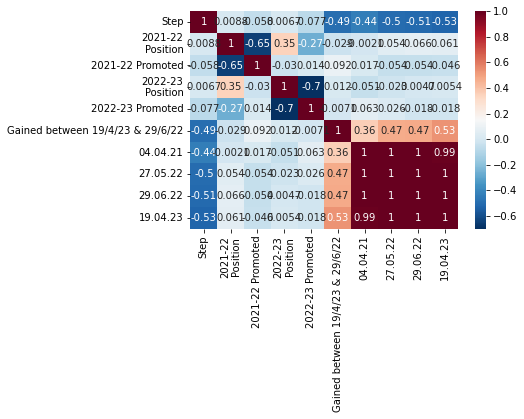

In [91]:
corr_matrix = X_num.corr(method='pearson')  # 'pearson' is default
 
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

In [89]:
pipeline = Pipeline([("transform",StandardScaler()),("classifier",SVC(max_iter = 10000))])

pipeline.fit(x_train,y_train)
pipeline.predict(x_test)
print(pipeline.score(x_test,y_test))
np.unique(y_test,return_counts=True)
#Now have altered the model such that the features remain as the gained twitter followers but the labels are now "positional improvement".
#Next we will tune the hyperperameters and use things like gridsearch to improve our score. 
distributions = {'kernel': ['linear','poly','rbf'], 'C': uniform(loc=0, scale=100),"gamma":uniform(loc=0,scale=100)}
clf = RandomizedSearchCV(SVC(max_iter=10000), distributions, n_iter=20)
clf.fit(x_train,y_train)
print(clf.best_estimator_)
clf.cv_results_['mean_test_score']

C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but StandardScaler is expecting 6 features as input.

In [85]:
sfs = SFS(LinearSVC(max_iter=10000),
           k_features=3, # number of features to select
           forward=True,
           floating=False,
           scoring='accuracy',
           cv=5)
x_num=football[["2021-22\nPosition","2021-22 Promoted","06.12.18","17.01.19","26.03.19","12.02.20","03.06.20","20.09.20","10.10.20","18.11.20","03.02.21","04.04.21","22.01.22","27.05.22","29.06.22","06.10.22","18.12.22","19.04.23","15.07.23"]]
sfs.fit(x_num,
        football["Positional Improvement"])
print(sfs.subsets_)


C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expl

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 300, in fit
    X, y = self._validate_data(
  File "C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
  File "C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 959, in check_array
    _assert_all_finite(
  File "C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LinearSVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [86]:
plot_sfs(sfs.get_metric_dict())
plt.show()

AttributeError: SequentialFeatureSelector has not been fitted, yet.